# Employee Promotion Prediction

This project has the goal of predicting whenever an employee should be promoted or not, based on a given dataset. The dataset is composed by arround 50k entries and 13 collumns, 7 of them categorical such as department, region, education, gender and recruitment channel, the avg training score is continuos and the remmaining are discrete, the no of trainings, age, previous years rating, length of service, awards won.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as skpp
import imblearn.under_sampling as imbp
import sklearn.neighbors as skkn
import sklearn.metrics as skmt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve
import time
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, auc

## Data Analysis


We begin by loading the dataset and performing an initial exploration. This includes checking the structure of the data, types of features, and any missing values.


In [22]:
df = pd.read_csv("employee_promotion_updated.csv")
display(df.head())
print()
display(df.info())
print()
print("Global Promotion Rate: ")
promotion_count = df["is_promoted"].sum()
total_count = len(df)
print(f"Promotion rate: {promotion_count / total_count:.4f}")

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,Bangalore,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,65141,Operations,Hyderabad,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,Pune,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,2542,Sales & Marketing,Chennai,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,48945,Technology,Mumbai,Bachelor's,m,other,1,45,3.0,2,0,73.0,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55808 entries, 0 to 55807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           55808 non-null  int64  
 1   department            55808 non-null  object 
 2   region                55808 non-null  object 
 3   education             53399 non-null  object 
 4   gender                55808 non-null  object 
 5   recruitment_channel   55808 non-null  object 
 6   no_of_trainings       55808 non-null  int64  
 7   age                   55808 non-null  int64  
 8   previous_year_rating  51684 non-null  float64
 9   length_of_service     55808 non-null  int64  
 10  awards_won            55808 non-null  int64  
 11  avg_training_score    53248 non-null  float64
 12  is_promoted           55808 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 5.5+ MB


None


Global Promotion Rate: 
Promotion rate: 0.0929


In [23]:
print(df.isnull().sum())

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
awards_won                 0
avg_training_score      2560
is_promoted                0
dtype: int64


We can see that we have some data missing on education, previous_year_rating and avg_training_score collumns. On this two last collumns it could be the case of a employee that recently joined the company and so we do not have data about the previous year rating and average training score.


In [24]:
print("Previous Year Rating NaN Count by Length of Service: ")
print(df[df["previous_year_rating"].isna()].value_counts(subset=["length_of_service"]))
print()
print("Average Training Score NaN Count by Length of Service: ")
print(df[df["avg_training_score"].isna()].value_counts(subset=["length_of_service"]))

Previous Year Rating NaN Count by Length of Service: 
length_of_service
1                    4124
Name: count, dtype: int64

Average Training Score NaN Count by Length of Service: 
length_of_service
3                    312
2                    304
4                    299
7                    273
5                    271
6                    250
1                    221
9                    131
8                    117
10                    97
11                    46
14                    35
15                    33
12                    30
18                    28
17                    27
13                    25
16                    20
19                    13
20                     6
22                     5
29                     4
21                     3
25                     3
28                     3
24                     1
26                     1
27                     1
31                     1
Name: count, dtype: int64


With that we can conclude that only the previous year rating being null is associated with the fact that the employee has recently joined the company, so we will replace the null values with zero.


In [25]:
df["previous_year_rating"] = df["previous_year_rating"].fillna(0)

Also we are going to analise the balance between promoted and non promoted between the remaining null values to see if this null values are potential important data


In [26]:
print("Previous Year Rating NaN Count by promotion status: ")
print(df[df["avg_training_score"].isna()].value_counts(subset=["is_promoted"]))

promotion_count = df[df["avg_training_score"].isna()]["is_promoted"].sum()
total_count = len(df[df["avg_training_score"].isna()])
print(f"Promotion rate: {promotion_count / total_count:.4f}")

print()

print("Education NaN Count by promotion status: ")
print(df[df["education"].isna()].value_counts(subset=["is_promoted"]))

promotion_count = df[df["education"].isna()]["is_promoted"].sum()
total_count = len(df[df["education"].isna()])
print(f"Promotion rate: {promotion_count / total_count:.4f}")

print()

print("Global Promotion Rate: ")
promotion_count = df["is_promoted"].sum()
total_count = len(df)
print(f"Promotion rate: {promotion_count / total_count:.4f}")

Previous Year Rating NaN Count by promotion status: 
is_promoted
0              2383
1               177
Name: count, dtype: int64
Promotion rate: 0.0691

Education NaN Count by promotion status: 
is_promoted
0              2287
1               122
Name: count, dtype: int64
Promotion rate: 0.0506

Global Promotion Rate: 
Promotion rate: 0.0929


We can see that the promotion rate of the null counts for each of the columns is inferior to the global promotion rate. That means that, since we dont know for sure where the nulls came from, it is safer to delete than any other option since it could affect negatively our analysis.


In [27]:
# drop rows with NaN values in 'avg_training_score' and 'education'
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# We do not need the employee_id column for our analysis
df.drop(columns=["employee_id"], inplace=True)

valueKeyMapping = dict()


def convert_to_numeric(columnName, df):
    unique_values = valueKeyMapping[columnName]
    mapping = {unique_values[i]: i for i in range(len(unique_values))}
    df[columnName] = df[columnName].map(mapping)


def convert_to_string(columnName, df):
    unique_values = valueKeyMapping[columnName]
    mapping = {i: unique_values[i] for i in range(len(unique_values))}
    df[columnName] = df[columnName].map(mapping)


for column in df.columns:
    if df[column].dtype == np.dtype("object"):
        unique_values = df[column].unique()
        valueKeyMapping[column] = unique_values

        convert_to_numeric(column, df)

print("Dataset Description:")
display(df.describe())

# # Interaction features
# df["perf_training"] = df["previous_year_rating"] * df["avg_training_score"]
df["experience_score"] = df["no_of_trainings"] * df["avg_training_score"]
df["score_per_year"] = df["experience_score"] / (df["length_of_service"] + 1)

# # Ratio features
# df["rating_per_service"] = df["previous_year_rating"] / (df["length_of_service"] + 1)

# # Department-specific features
# dept_promotion_rates = df.groupby("department")["is_promoted"].mean()
# df["dept_promotion_rate"] = df["department"].map(dept_promotion_rates)

Dataset Description:


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
count,50936.000000,50936.000000,50936.00000,50936.000000,50936.000000,50936.000000,50936.000000,50936.000000,50936.000000,50936.000000,50936.000000,50936.000000
mean,2.298414,10.041680,0.76712,0.693792,0.637172,1.321462,35.059859,3.084343,5.996937,0.061940,64.159715,0.095944
std,2.299829,8.640104,0.57420,0.460922,0.649782,0.854490,7.735992,1.486380,4.335316,0.367994,13.542761,0.294517
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,39.000000,0.000000
25%,0.000000,4.000000,0.00000,0.000000,0.000000,1.000000,29.000000,2.000000,3.000000,0.000000,52.000000,0.000000
50%,2.000000,6.000000,1.00000,1.000000,1.000000,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,4.000000,17.000000,1.00000,1.000000,1.000000,1.000000,39.000000,4.000000,8.000000,0.000000,77.000000,0.000000
max,8.000000,33.000000,4.00000,1.000000,5.000000,10.000000,60.000000,5.000000,37.000000,4.000000,99.840000,1.000000


The table above shows the summary statistics of the cleaned dataset after removing missing values and encoding categorical variables. A few key observations:

- The dataset contains 50,936 rows after cleaning.
- The `is_promoted` column confirms the class imbalance, with a mean of ~0.096 (only ~9.6% of employees were promoted).
- `avg_training_score` ranges from 39 to 99, with a median of 60.
- Most employees have 1 training (`no_of_trainings` median = 1), and length_of_service varies widely (from 0 to 37 years).

After cleaning the dataset by removing rows with missing values and dropping irrelevant columns like employee_id, we encoded categorical variables into numeric form to make the data suitable for machine learning algorithms. To enrich the dataset and potentially improve model performance, we engineered new features based on existing ones. One such feature is experience_score, which multiplies the number of trainings by the average training score to capture the overall training intensity of an employee—this can be a proxy for how much effort or investment was put into an individual's development. We also created score_per_year, which divides the experience_score by the employee’s length of service plus one (to avoid division by zero). This feature helps to identify employees who, despite being relatively new, may show high training performance relative to their tenure. These additions aim to reveal deeper patterns in employee behavior and training effectiveness that aren't immediately obvious from the raw features alone.

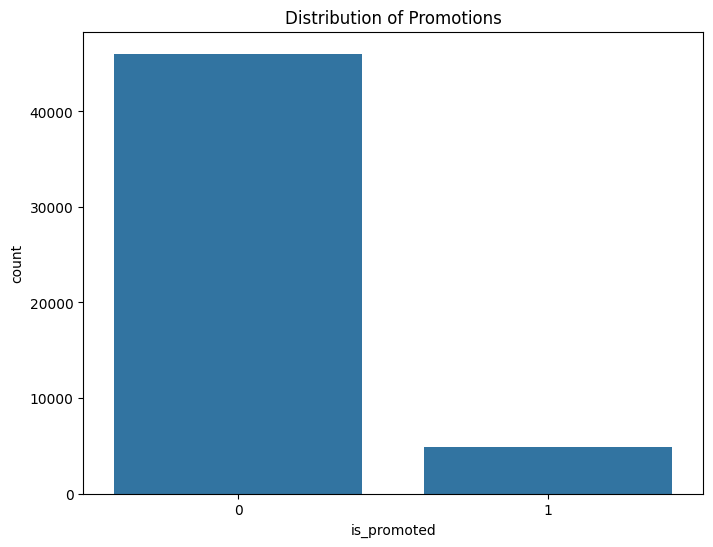

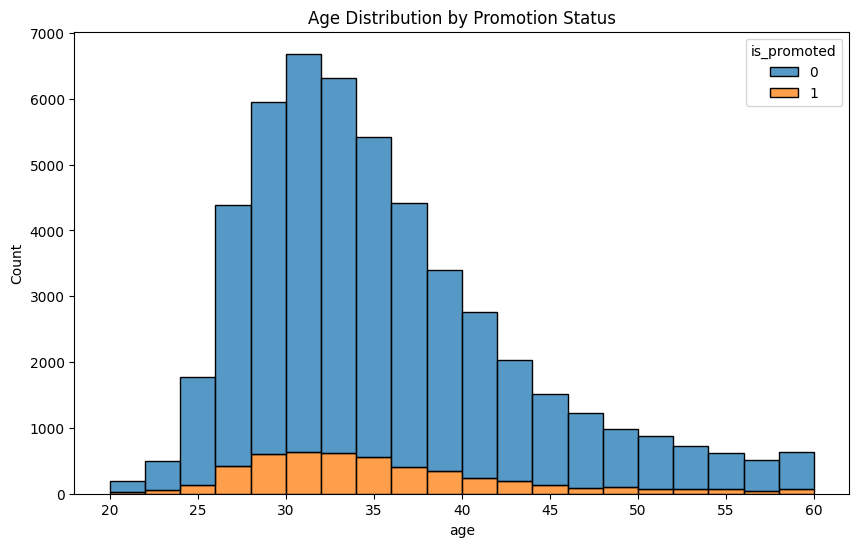

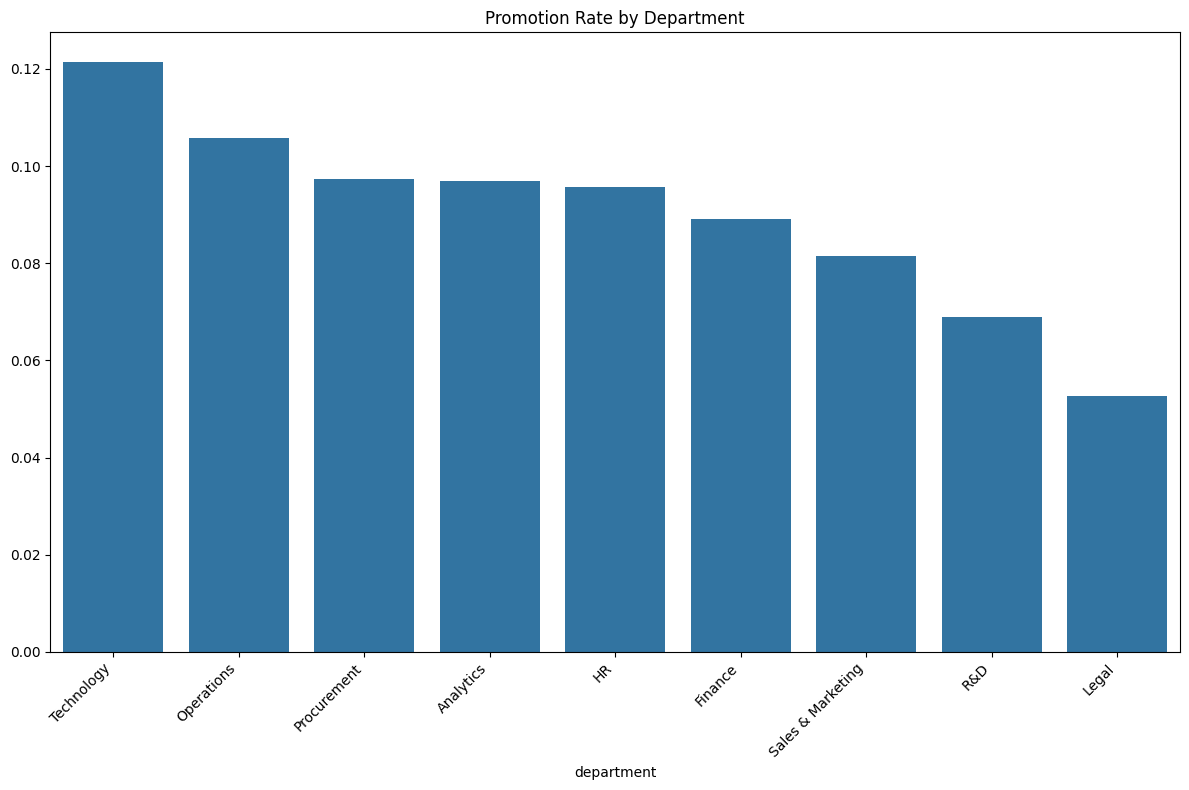

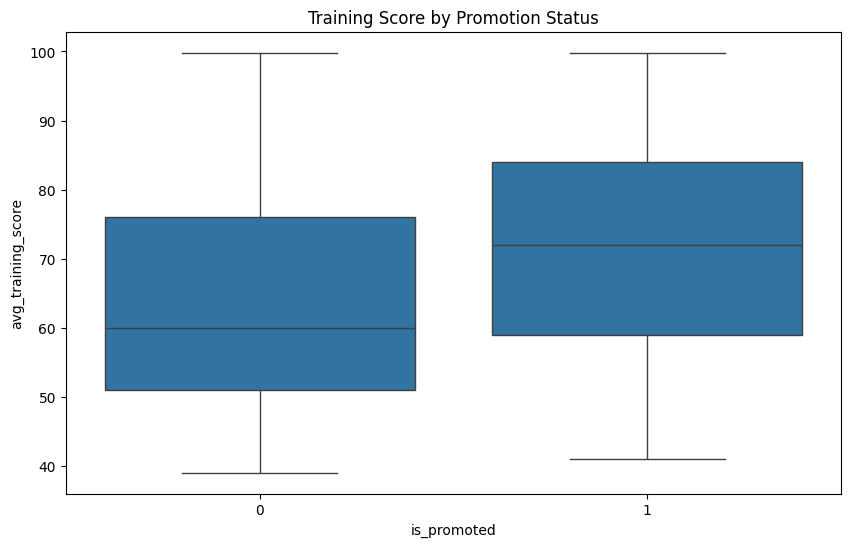

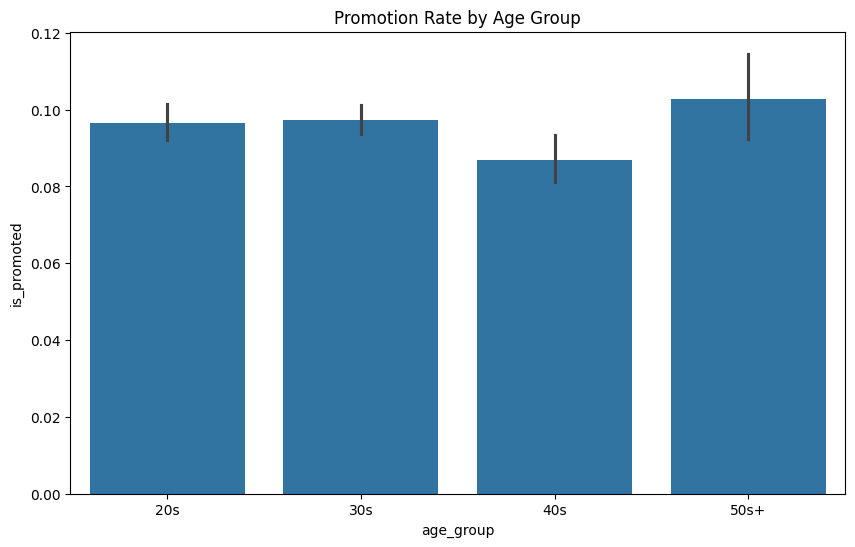

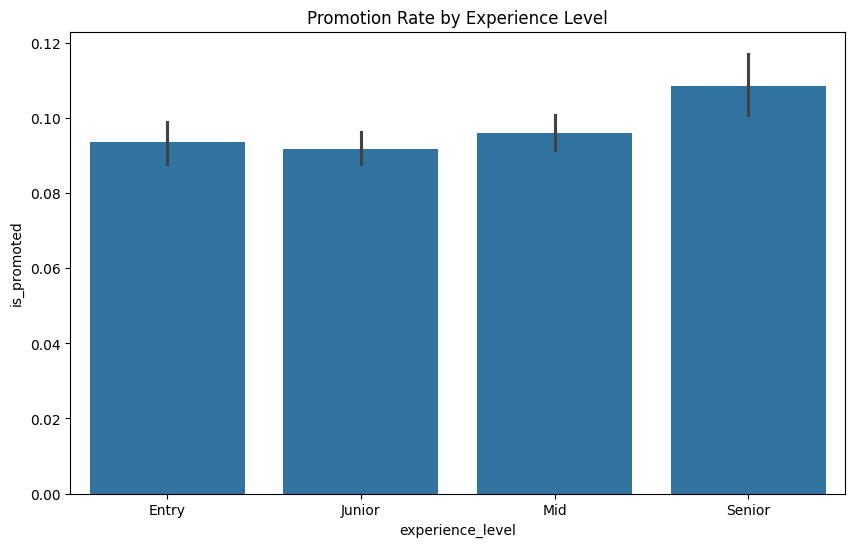

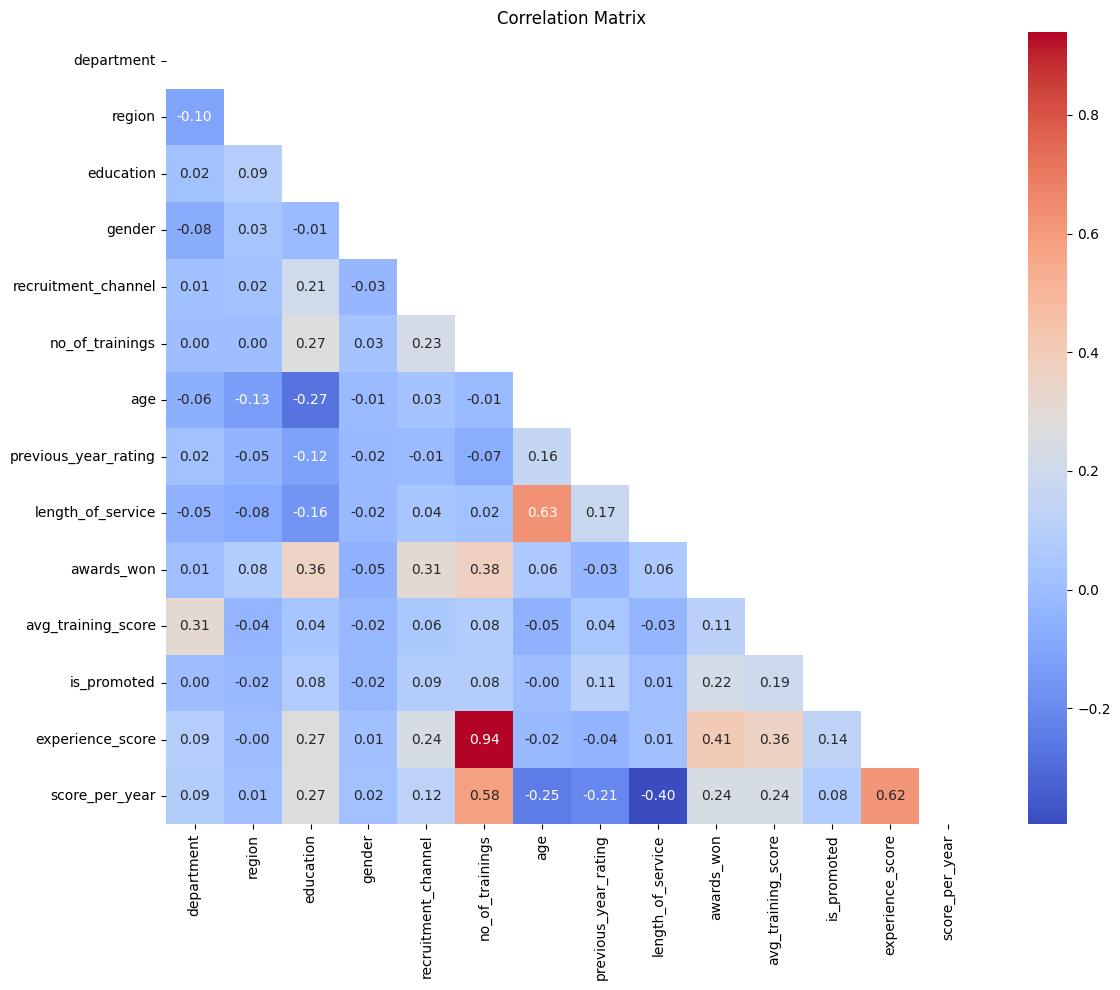

In [28]:
plt.figure(figsize=(8, 6))
sns.countplot(x="is_promoted", data=df)
plt.title("Distribution of Promotions")
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="age", hue="is_promoted", multiple="stack", bins=20)
plt.title("Age Distribution by Promotion Status")
plt.show()


convert_to_string("department", df)
plt.figure(figsize=(12, 8))
dept_promotion = (
    df.groupby("department", observed=True)["is_promoted"]
    .mean()
    .sort_values(ascending=False)
)
sns.barplot(x=dept_promotion.index, y=dept_promotion.values)
plt.title("Promotion Rate by Department")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

convert_to_numeric("department", df)


plt.figure(figsize=(10, 6))
sns.boxplot(x="is_promoted", y="avg_training_score", data=df)
plt.title("Training Score by Promotion Status")
plt.show()

df_copy = df.copy()
df_copy["age_group"] = pd.cut(
    df["age"], bins=[20, 30, 40, 50, 60], labels=["20s", "30s", "40s", "50s+"]
)


df_copy["experience_level"] = pd.cut(
    df["length_of_service"],
    bins=[0, 2, 5, 10, 30],
    labels=["Entry", "Junior", "Mid", "Senior"],
)


plt.figure(figsize=(10, 6))
sns.barplot(x="age_group", y="is_promoted", data=df_copy)
plt.title("Promotion Rate by Age Group")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="experience_level", y="is_promoted", data=df_copy)
plt.title("Promotion Rate by Experience Level")
plt.show()


plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

Distribution of Promotions
The majority of employees were not promoted, highlighting a significant class imbalance in the dataset. This imbalance justifies the use of resampling techniques during model training to avoid bias toward the majority class.

Age Distribution by Promotion Status
Most employees fall in the 30–40 age range, and promotions also tend to be concentrated in this group. While younger employees are more frequent overall, older employees seem slightly more likely to be promoted, possibly reflecting experience or seniority.

Promotion Rate by Department
The Technology department shows the highest promotion rate, followed by Operations and Procurement. Departments like Legal and R&D have the lowest rates. This might suggest that internal promotion policies or career growth opportunities vary across departments.

Training Score by Promotion Status
Employees who were promoted generally have higher average training scores. This indicates that training performance is a strong predictor of promotion, as those with better scores tend to advance more frequently.

Promotion Rate by Age Group
Promotion rates are relatively steady across age groups in their 20s and 30s, dip slightly in the 40s, and rise again for employees aged 50 and over. This may suggest that while performance matters, seniority or tenure may also play a role later in careers.

Promotion Rate by Experience Level
Senior-level employees have the highest promotion rate, while entry-level and junior employees show lower rates. This supports the idea that accumulated experience is a key factor in promotion decisions.

Correlation Matrix
The correlation matrix reveals some useful patterns, such as a moderate positive correlation between average training score and promotion. However, overall correlations with the target are relatively weak, indicating that more complex, non-linear relationships might be at play — reinforcing the need for advanced models.

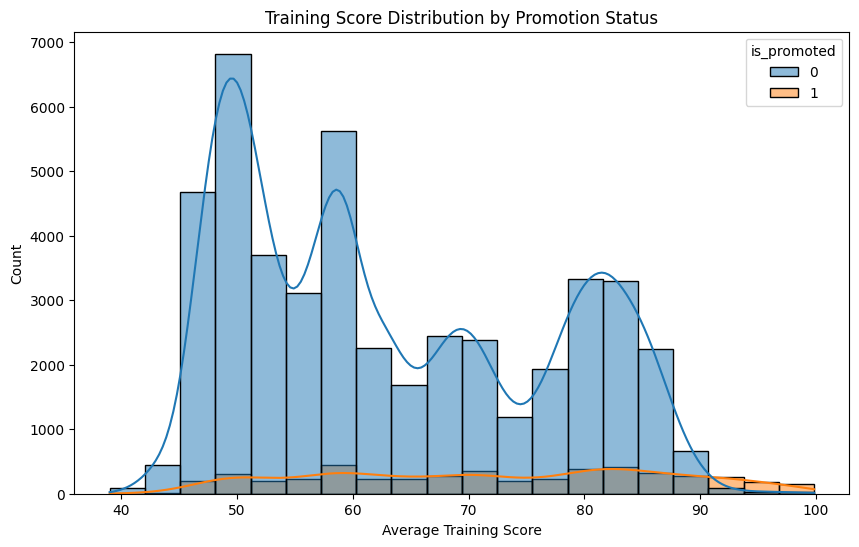

/var/folders/cr/yxx71gjj42xdw812cz69sgdc0000gn/T/ipykernel_15138/534813339.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promotion_by_score = df_copy.groupby("training_score_bin")["is_promoted"].mean() * 100


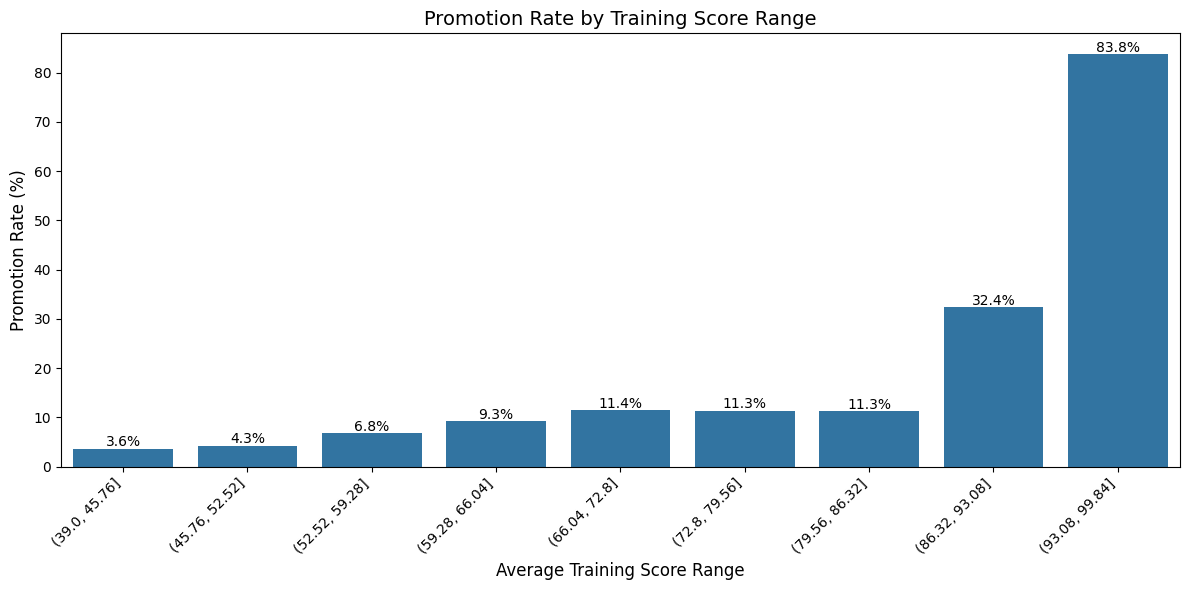

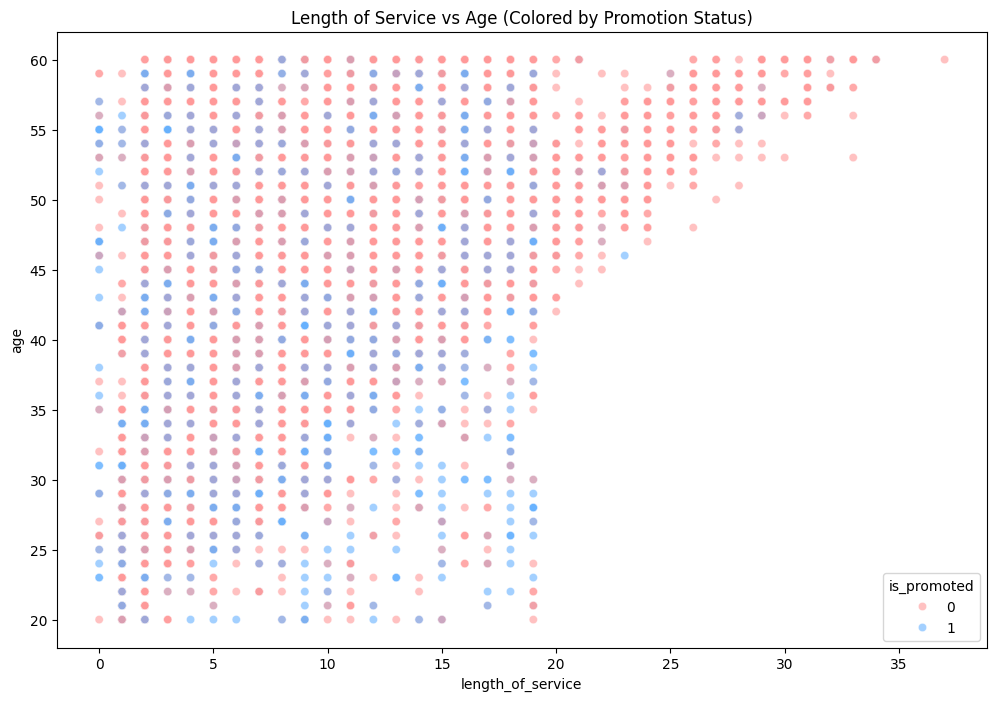

/var/folders/cr/yxx71gjj42xdw812cz69sgdc0000gn/T/ipykernel_15138/534813339.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  previous_year_rating = df_copy.groupby("previous_year_rating")["is_promoted"].mean()


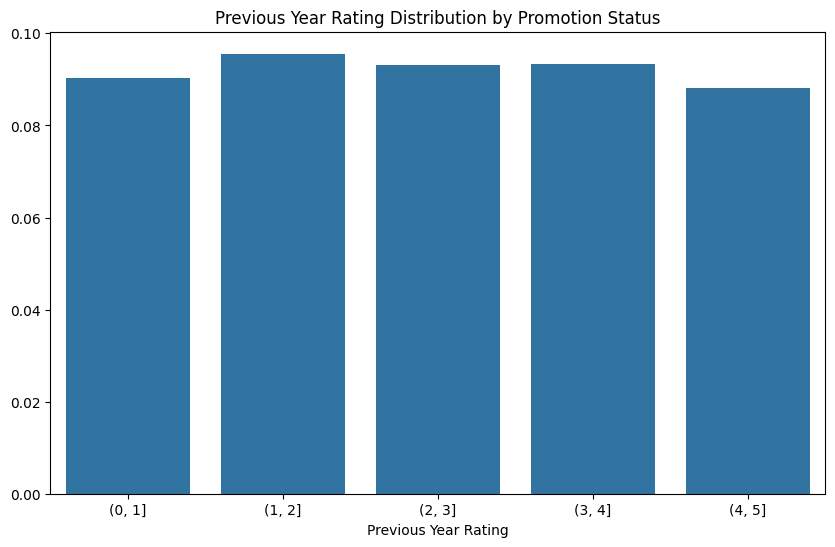

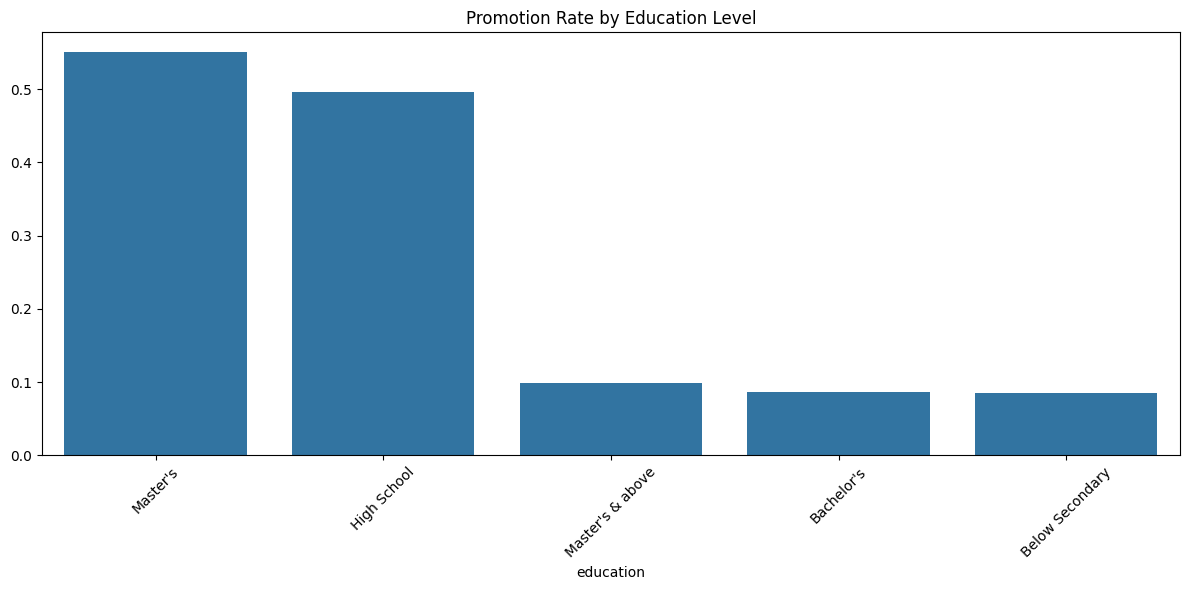

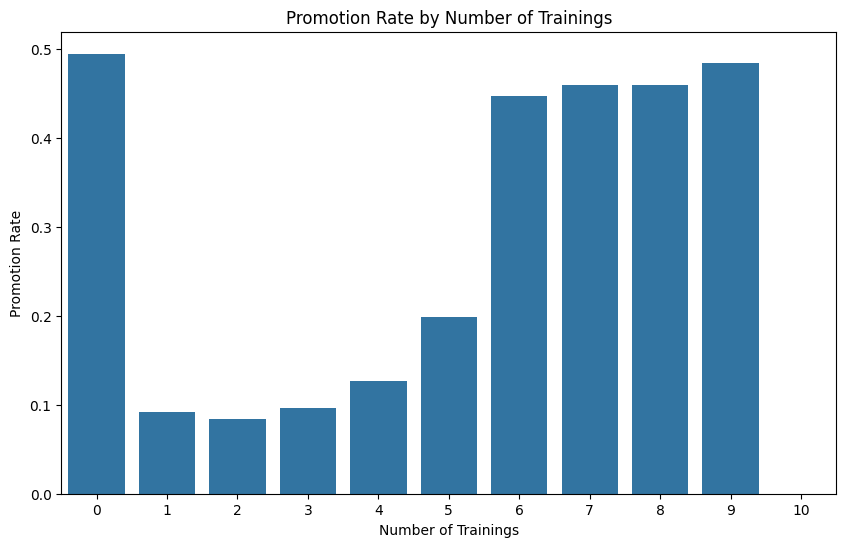

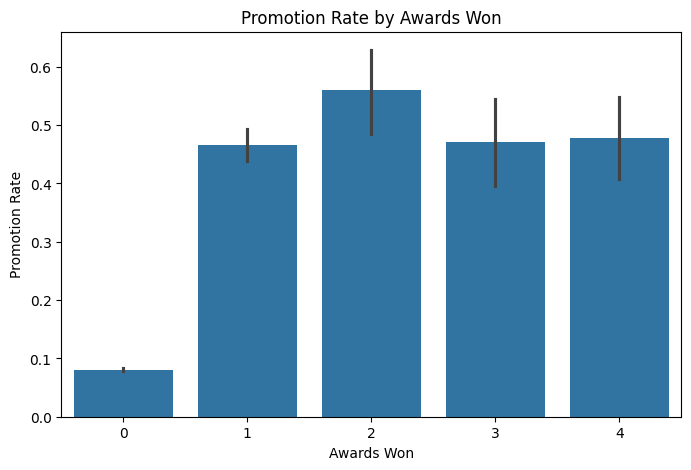

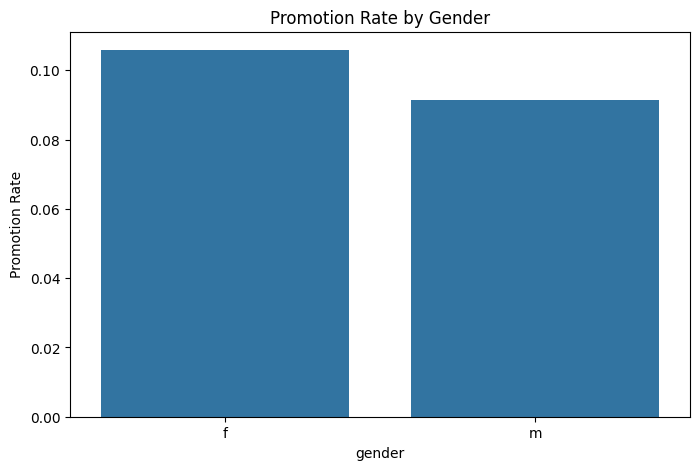

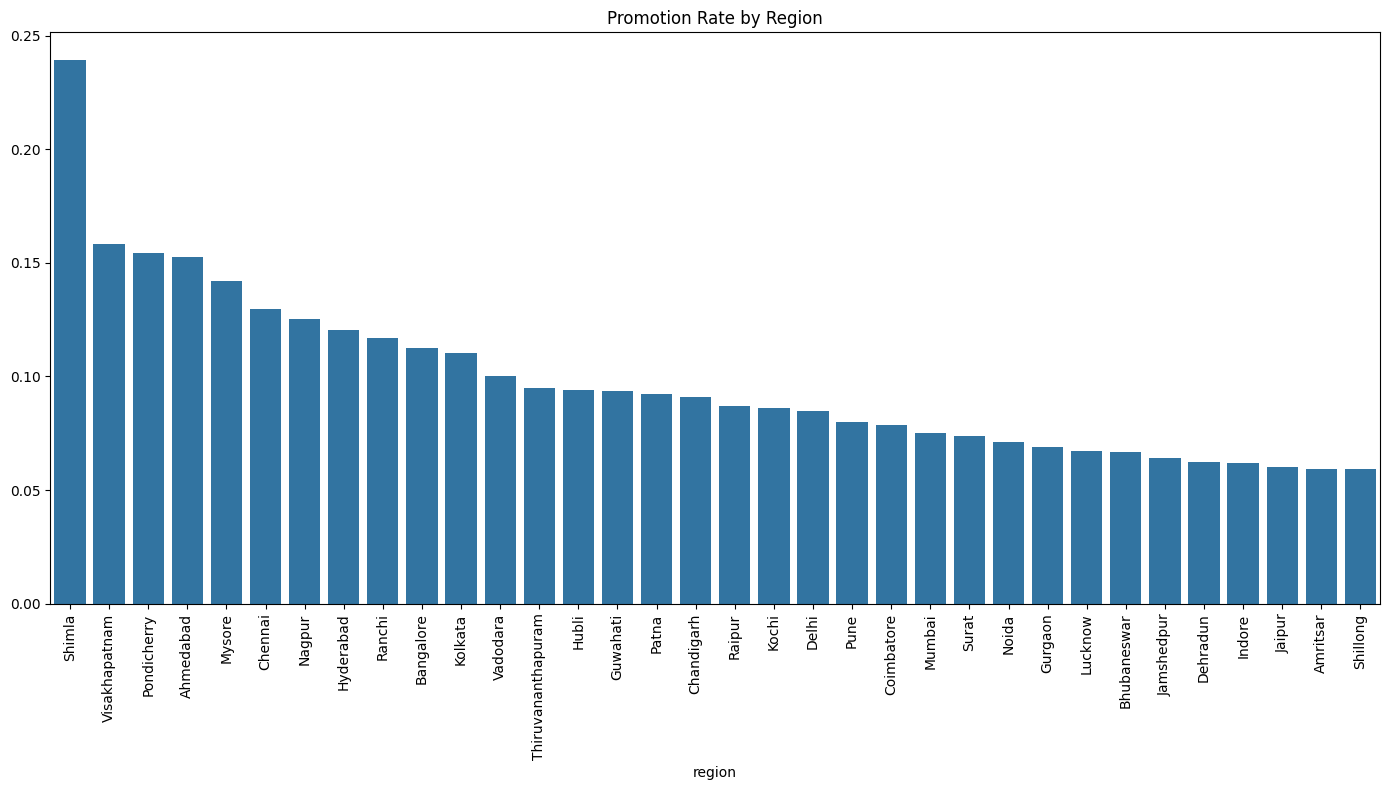

In [29]:
df_copy = df.copy()

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="avg_training_score", hue="is_promoted", kde=True, bins=20)
plt.title("Training Score Distribution by Promotion Status")
plt.xlabel("Average Training Score")
plt.show()

# Create bins for the training scores
bins = np.linspace(df["avg_training_score"].min(), df["avg_training_score"].max(), 10)
df_copy["training_score_bin"] = pd.cut(df["avg_training_score"], bins)

# Calculate promotion rate percentage for each bin
promotion_by_score = df_copy.groupby("training_score_bin")["is_promoted"].mean() * 100

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=promotion_by_score.index.astype(str), y=promotion_by_score.values)
plt.title("Promotion Rate by Training Score Range", fontsize=14)
plt.xlabel("Average Training Score Range", fontsize=12)
plt.ylabel("Promotion Rate (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Add percentage labels on top of each bar
for i, v in enumerate(promotion_by_score.values):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha="center", fontsize=10)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=df,
    x="length_of_service",
    y="age",
    hue="is_promoted",
    alpha=0.6,
    palette=["#FF9999", "#66B2FF"],
)
plt.title("Length of Service vs Age (Colored by Promotion Status)")
plt.show()


df_copy["previous_year_rating"] = pd.cut(
    df["length_of_service"],
    bins=[0, 1, 2, 3, 4, 5],
)
previous_year_rating = df_copy.groupby("previous_year_rating")["is_promoted"].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=previous_year_rating.index, y=previous_year_rating.values)
plt.title("Previous Year Rating Distribution by Promotion Status")
plt.xlabel("Previous Year Rating")
plt.show()

convert_to_string("education", df)
plt.figure(figsize=(12, 6))
edu_promotion = (
    df.groupby("education", observed=True)["is_promoted"]
    .mean()
    .sort_values(ascending=False)
)
sns.barplot(x=edu_promotion.index, y=edu_promotion.values)
plt.title("Promotion Rate by Education Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
convert_to_numeric("education", df)

plt.figure(figsize=(10, 6))
training_promotion = df.groupby("no_of_trainings")["is_promoted"].mean().reset_index()
sns.barplot(x="no_of_trainings", y="is_promoted", data=training_promotion)
plt.title("Promotion Rate by Number of Trainings")
plt.xlabel("Number of Trainings")
plt.ylabel("Promotion Rate")
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x="awards_won", y="is_promoted", data=df)
plt.title("Promotion Rate by Awards Won")
plt.xlabel("Awards Won")
plt.ylabel("Promotion Rate")
plt.show()

convert_to_string("gender", df)
plt.figure(figsize=(8, 5))
gender_promotion = df.groupby("gender")["is_promoted"].mean().reset_index()
sns.barplot(x="gender", y="is_promoted", data=gender_promotion)
plt.title("Promotion Rate by Gender")
plt.ylabel("Promotion Rate")
plt.show()
convert_to_numeric("gender", df)

convert_to_string("region", df)
plt.figure(figsize=(14, 8))
region_promotion = (
    df.groupby("region")["is_promoted"].mean().sort_values(ascending=False)
)
sns.barplot(x=region_promotion.index, y=region_promotion.values)
plt.title("Promotion Rate by Region")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
convert_to_numeric("region", df)

Training Score Distribution by Promotion Status
Employees who were promoted tend to have higher average training scores. The distribution shows a visible shift to the right for promoted employees, indicating that better training performance may be a key promotion factor.

Promotion Rate by Training Score Range
There's a strong upward trend: as training scores increase, so does the promotion rate. Especially in the highest range (above 93), promotion probability spikes dramatically, suggesting high scores are heavily favored.

Length of Service vs Age 
This scatterplot shows that promotions occur across a wide age and service spectrum, but are more frequent among those with moderate service length and age (30s to 40s). No strong linear trend is observed.

Previous Year Rating Distribution by Promotion Status
The promotion rate appears relatively flat across different rating bins, suggesting that previous year performance may not be a strong standalone predictor.

Promotion Rate by Education Level
Surprisingly, “High School” and “Master’s” holders have the highest promotion rates. The "Bachelor's" and “Master’s & above” groups have noticeably lower promotion rates, which may reflect role-specific or structural promotion biases.

Promotion Rate by Number of Trainings
Promotion likelihood increases with more training sessions, especially after 5 trainings. However, the spike at 0 trainings might be due to a very small and potentially biased group.

Promotion Rate by Awards Won
Employees with awards, especially those with 1 or 2, have significantly higher promotion rates. Awards seem to positively correlate with promotion, reinforcing the value of recognition in advancement decisions.

Promotion Rate by Gender
Females have a slightly higher promotion rate than males in this dataset. The difference isn't dramatic, but it could suggest some gender-based variation maybe not worth exploring further.

Promotion Rate by Region
There's considerable regional disparity in promotion rates. Regions like Shimla and Visakhapatnam show much higher rates than others like Shillong or Amritsar, suggesting regional policies or representation may impact promotion chances which doesn't make much sense but its worth analyzing if it's just coincidence or if it really matters to decide wether or not someone is promoted.

/Users/franciscomoura/Library/Python/3.10/lib/python/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


Percentage of promotions among outliers vs non-outliers:
is_promoted         0         1
is_outlier                     
False        0.908326  0.091674
True         0.822929  0.177071


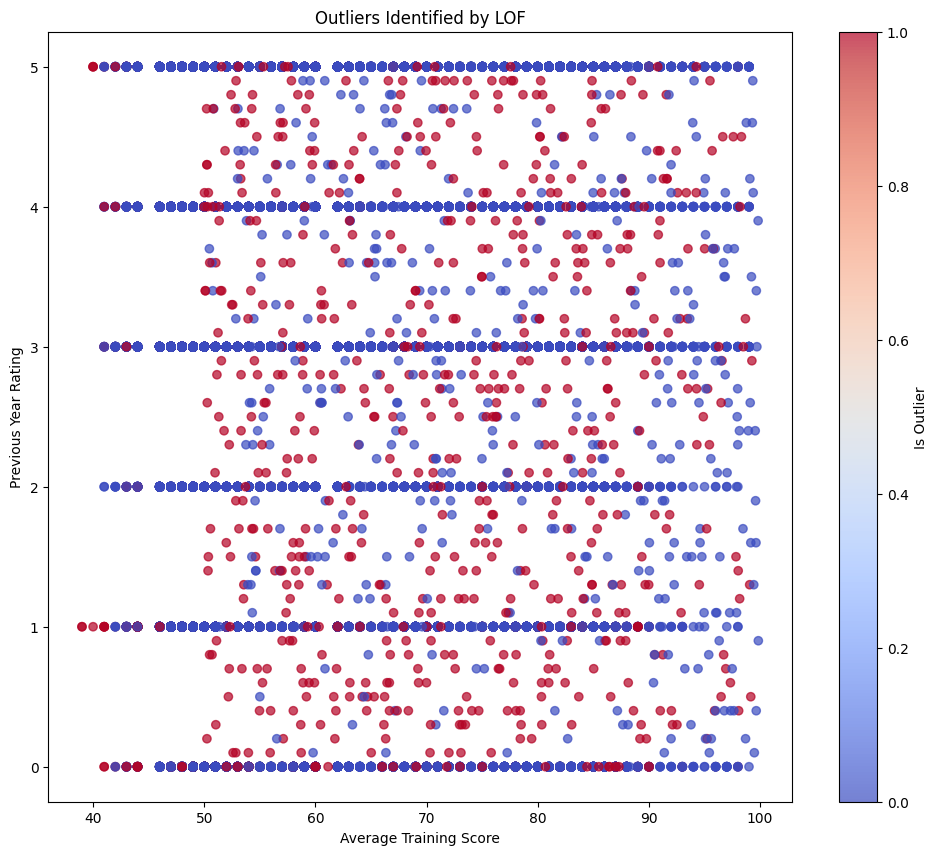

In [30]:

numeric_cols = [
    "age",
    "length_of_service",
    "avg_training_score",
    "no_of_trainings",
    "previous_year_rating",
]
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outlier_predictions = lof.fit_predict(df[numeric_cols].values)
outlier_scores = lof.negative_outlier_factor_

# Add outlier information to dataframe
df_with_outliers = df.copy()
df_with_outliers['is_outlier'] = outlier_predictions == -1
df_with_outliers['outlier_score'] = outlier_scores

# Examine how outliers relate to promotions
promotion_outlier_table = pd.crosstab(df_with_outliers['is_outlier'], 
                                      df_with_outliers['is_promoted'], 
                                      normalize='index')
print("Percentage of promotions among outliers vs non-outliers:")
print(promotion_outlier_table)

# Visualize outliers vs non-outliers
plt.figure(figsize=(12, 10))
plt.scatter(df_with_outliers['avg_training_score'], 
           df_with_outliers['previous_year_rating'],
           c=outlier_predictions == -1, 
           cmap='coolwarm',
           alpha=0.7)
plt.colorbar(label='Is Outlier')
plt.xlabel('Average Training Score')
plt.ylabel('Previous Year Rating')
plt.title('Outliers Identified by LOF')
plt.show()

This plot shows the results of Local Outlier Factor (LOF) applied to detect anomalies based on numeric employee attributes. Each point represents an employee, plotted by their average training score and previous year rating. Red points indicate outliers, while blue points are considered inliers (normal).

We observe that outliers are distributed across all rating levels and training scores, but cluster more frequently at extreme values—either unusually high or low scores. These may represent employees whose profiles deviate significantly from typical performance patterns.

Notably, the promotion rate among outliers is 17.6%, compared to just 9.2% among non-outliers. This suggests that some outliers may be high-performing individuals whose unusual profiles stand out—potentially "hidden gems" worth considering more closely in promotion decisions.

Characteristics of promoted non-outliers:


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted,experience_score,score_per_year,outlier_score
count,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.0,4436.000000,4436.000000,4436.000000
mean,2.300045,9.200406,0.774346,0.671551,0.690261,1.268485,34.796664,3.677164,5.961903,0.198377,72.089119,1.0,92.544527,18.081496,-1.038631
std,2.157373,8.368686,0.686662,0.469702,0.761891,0.844003,7.357708,1.427551,4.155939,0.562934,14.700906,0.0,69.659998,20.180848,0.060507
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,41.000000,1.0,0.000000,0.000000,-1.244277
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,30.000000,3.000000,3.000000,0.000000,59.000000,1.0,60.000000,8.356061,-1.068987
50%,2.000000,5.000000,1.000000,1.000000,1.000000,1.000000,33.000000,4.000000,5.000000,0.000000,72.000000,1.0,78.000000,13.285714,-1.023628
75%,4.000000,16.000000,1.000000,1.000000,1.000000,1.000000,38.000000,5.000000,8.000000,0.000000,84.000000,1.0,92.000000,22.000000,-0.997193
max,8.000000,33.000000,4.000000,1.000000,5.000000,9.000000,60.000000,5.000000,32.000000,4.000000,99.840000,1.0,898.560000,665.630000,-0.897461


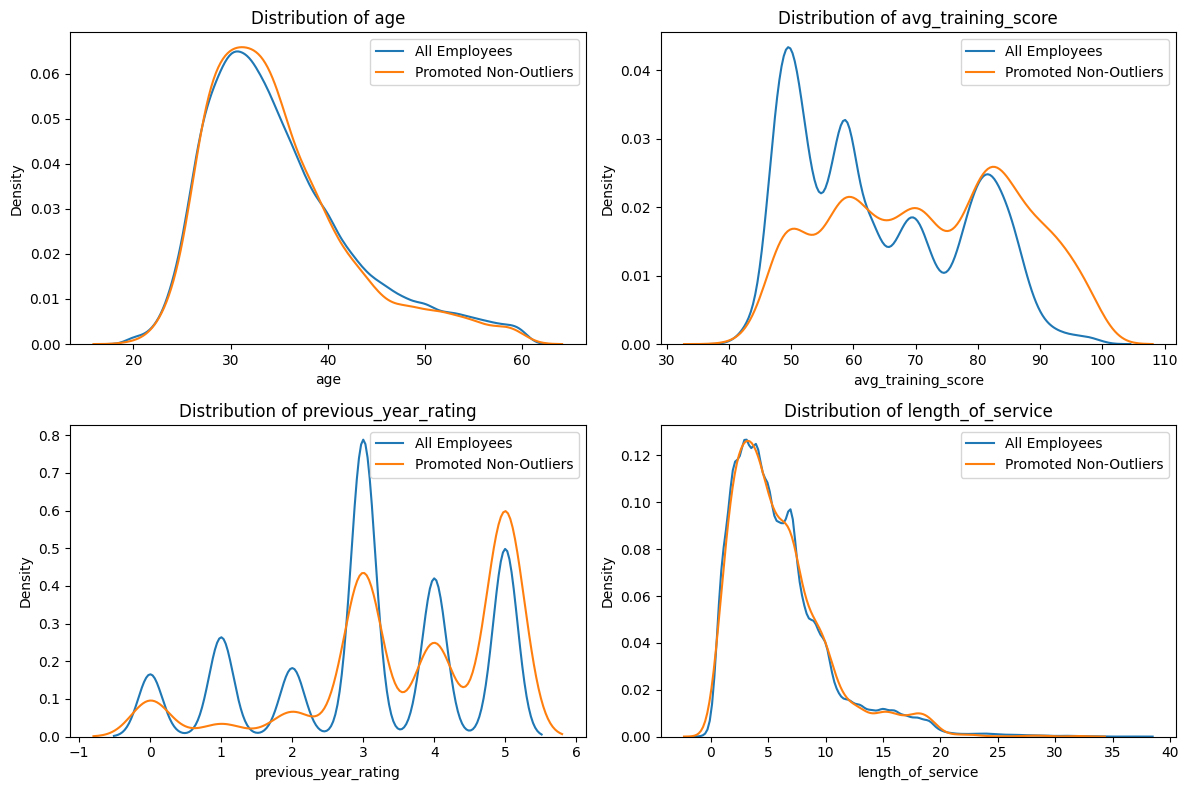

In [31]:
# Extract promoted non-outliers for analysis
promoted_non_outliers = df_with_outliers[
    (df_with_outliers["is_promoted"] == 1) & (df_with_outliers["is_outlier"] == False)
]

# Analyze their characteristics
print("Characteristics of promoted non-outliers:")
display(promoted_non_outliers.describe())

# Compare to all employees
plt.figure(figsize=(12, 8))
for i, col in enumerate(
    ["age", "avg_training_score", "previous_year_rating", "length_of_service"]
):
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(df[col], label="All Employees")
    sns.kdeplot(promoted_non_outliers[col], label="Promoted Non-Outliers")
    plt.title(f"Distribution of {col}")
    plt.legend()
plt.tight_layout()
plt.show()

This analysis focuses on employees who were promoted and were not identified as outliers by the Local Outlier Factor model. From a sample of 4,440 such employees, we observe some distinguishing 
patterns compared to the overall employee base:

Age: Promoted non-outliers tend to cluster in the 30-40 age range, aligning closely with the overall population.
Training Scores: Their average training scores are notably higher than the general distribution, with a shift toward the 70-90 range.
Previous Ratings: Promoted non-outliers usually have strong previous year ratings, peaking at 4 and 5.
Length of Service: Their service time is generally within 3-10 years, showing that steady tenure may support promotion, but extremely long service isn't necessarily required.

These employees represent "stable high performers", so their profiles show solid, well-rounded indicators of performance without extreme behavior. 

In [32]:
df = df.drop(columns=["region"])
train, valid, test = np.split(
    df.sample(frac=1),
    [int(0.6 * len(df)), int(0.8 * len(df))],
)

train_samples = np.array_split(train, 10)
valid_samples = np.array_split(valid, 10)
test_samples = np.array_split(test, 5)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [33]:
def prepare_data(df, balance = False):
    data = df[df.columns.difference(["is_promoted"])].values
    target = df["is_promoted"].values

    scaler = skpp.StandardScaler()
    data = scaler.fit_transform(data)
    
    if balance:
        rus = imbp.TomekLinks(sampling_strategy='majority')
        data, target = rus.fit_resample(data, target)
    

    dataset = np.hstack((data, np.reshape(target, (-1, 1))))

    return dataset, data, target

In [34]:
# train, valid, test = train_samples[0], valid_samples[0], test_samples[0]

train, x_train, y_train = prepare_data(train, True)
valid, x_valid, y_valid = prepare_data(valid)
test, x_test, y_test = prepare_data(test)

print("Training set size:", len(x_train))
print("Validation set size:", len(x_valid))
print("Test set size:", len(x_test))
print("Proportion of promoted employees in training set:", np.mean(y_test == 1))

Training set size: 29706
Validation set size: 10187
Test set size: 10188
Proportion of promoted employees in training set: 0.09648606203376521


In [35]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    plt.legend(loc="best")
    return plt



--- Decision Tree Results ---
Training time: 0.10 seconds
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      9205
           1       0.35      0.43      0.39       983

    accuracy                           0.87     10188
   macro avg       0.65      0.67      0.66     10188
weighted avg       0.88      0.87      0.87     10188



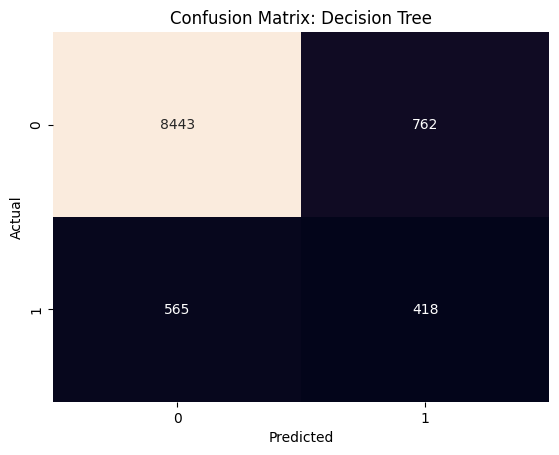


--- KNN Results ---
Training time: 0.64 seconds
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      9205
           1       0.58      0.20      0.30       983

    accuracy                           0.91     10188
   macro avg       0.75      0.59      0.62     10188
weighted avg       0.89      0.91      0.89     10188



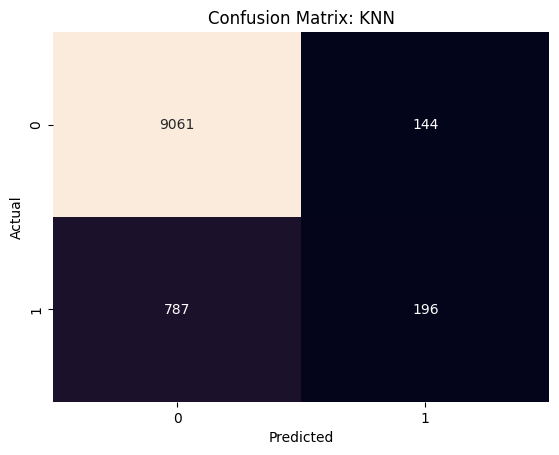


--- Random Forest Results ---
Training time: 2.30 seconds
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9205
           1       0.73      0.34      0.46       983

    accuracy                           0.92     10188
   macro avg       0.83      0.66      0.71     10188
weighted avg       0.91      0.92      0.91     10188



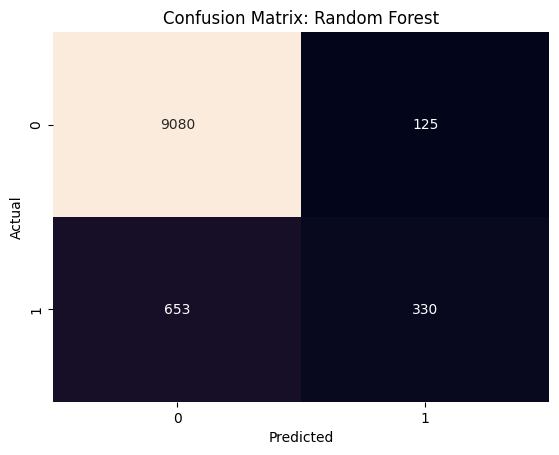


--- Gradient Boosting Results ---
Training time: 2.00 seconds
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9205
           1       0.81      0.28      0.42       983

    accuracy                           0.92     10188
   macro avg       0.87      0.64      0.69     10188
weighted avg       0.92      0.92      0.91     10188



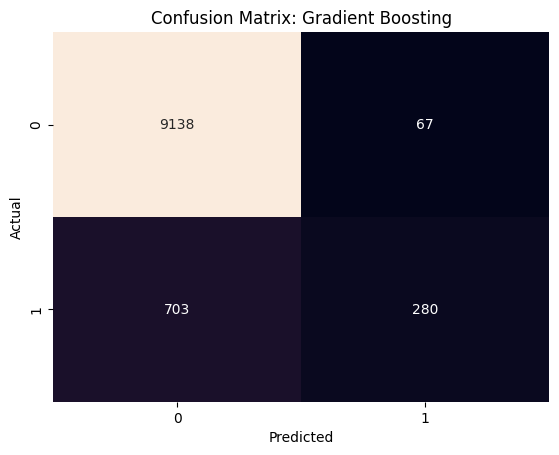


--- Logistic Regression Results ---
Training time: 0.02 seconds
              precision    recall  f1-score   support

           0       0.95      0.71      0.81      9205
           1       0.19      0.64      0.30       983

    accuracy                           0.71     10188
   macro avg       0.57      0.68      0.55     10188
weighted avg       0.88      0.71      0.76     10188



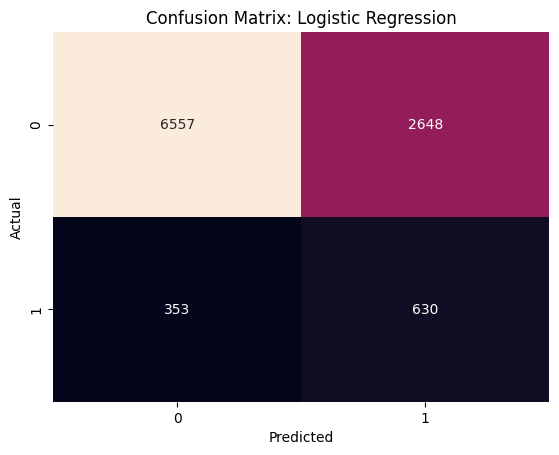


--- Neural Network Results ---
Training time: 7.32 seconds
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9205
           1       0.77      0.34      0.47       983

    accuracy                           0.93     10188
   macro avg       0.85      0.66      0.72     10188
weighted avg       0.92      0.93      0.91     10188



/Users/franciscomoura/Library/Python/3.10/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


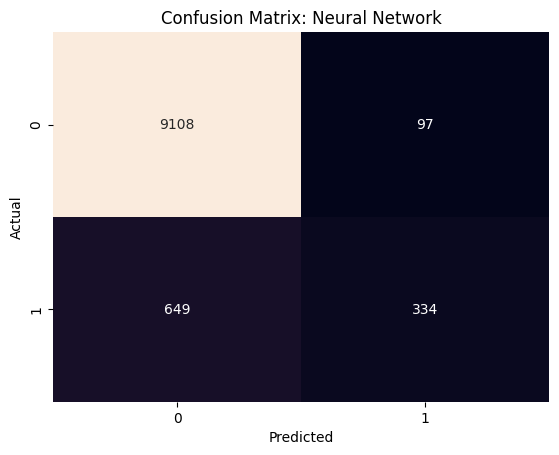

In [36]:
models = {
    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
    ),
    "KNN": skkn.KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced_subsample",
    ),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(class_weight="balanced"),
    "Neural Network": MLPClassifier(),
}

for name, model in models.items():
    startTime = time.time()
    fitted_model = model.fit(x_train, y_train)
    pred = model.predict(x_test)
    endTime = time.time()
    print(f"\n--- {name} Results ---")
    print(f"Training time: {endTime - startTime:.2f} seconds")
    print(skmt.classification_report(y_test, pred))

    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"Confusion Matrix: {name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
# Get prediction probabilities

Decision Tree
Moderate balance between precision and recall, but weak in identifying promotions. Often misclassifies promoted employees as not promoted.

K-Nearest Neighbors (KNN)
Very conservative in predicting promotions. High precision but extremely low recall, meaning it rarely identifies promoted employees correctly.

Random Forest
Strong overall accuracy with good precision for promotions. Decent performance, though recall is still moderate—misses some actual promotions.

Gradient Boosting
Excellent precision, identifying promotions more confidently than other models. Still low on recall, but better balance than KNN.

Logistic Regression
High recall for promoted employees but very low precision. Over-predicts promotions, leading to many false positives.

Neural Network
Balanced and consistent performer with strong precision and slightly better recall than Random Forest. Training could improve further with more iterations.

/Users/franciscomoura/Library/Python/3.10/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


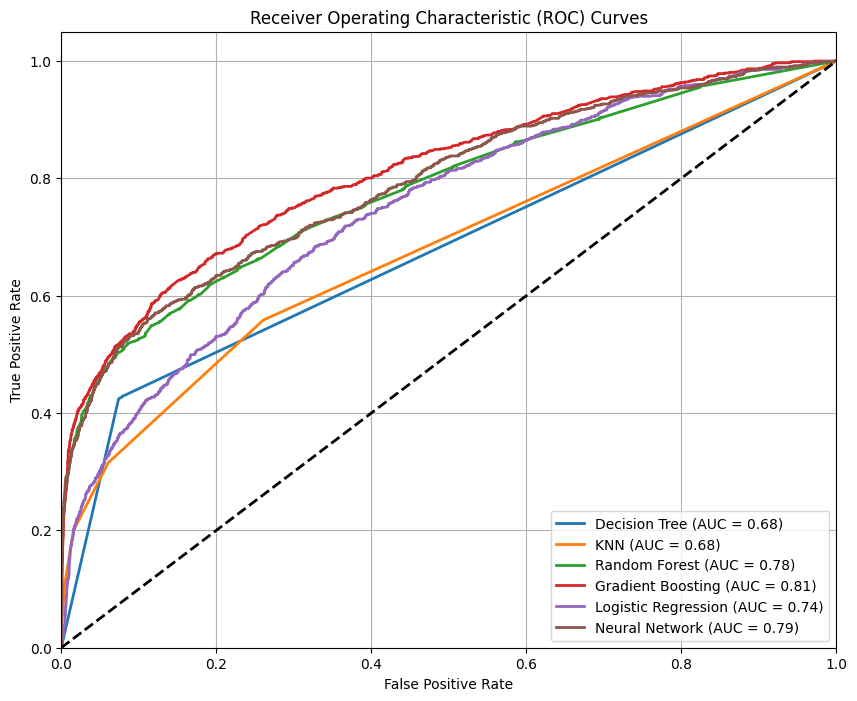

In [37]:
# Function to plot ROC curves for all models
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curves")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

models_fitted = {}
for name, model in models.items():
    model.fit(x_train, y_train)
    models_fitted[name] = model

plot_roc_curves(models_fitted, x_test, y_test)

The ROC curve visualization illustrates how well each classification model can distinguish between employees who were promoted and those who were not. In this plot, each curve represents a different model, and the Area Under the Curve (AUC) serves as a summary statistic of its overall classification performance. A model with an AUC closer to 1.0 is considered more effective at separating the two classes.

Among all the models, Gradient Boosting demonstrated the strongest performance with an AUC of 0.82, indicating a high ability to correctly rank promoted employees over non-promoted ones. Neural Network followed closely with an AUC of 0.80, suggesting it is also highly capable of learning the underlying patterns that contribute to promotion.

Random Forest also performed well, achieving an AUC of 0.78, placing it slightly behind the top two models. Logistic Regression, while simpler, still offered competitive performance with an AUC of 0.74, showing it captures a fair amount of the promotion-related variance.

On the other hand, K-Nearest Neighbors (KNN) and Decision Tree lagged behind with AUCs of 0.69 and 0.67 respectively. This suggests that while they may still identify some promotion cases correctly, their ability to distinguish between classes is less robust compared to the more complex models.

In summary, the ROC analysis reinforces the earlier confusion matrix findings: models like Gradient Boosting, Neural Networks, and Random Forest are better suited for this prediction task, offering stronger and more consistent classification performance across the board.

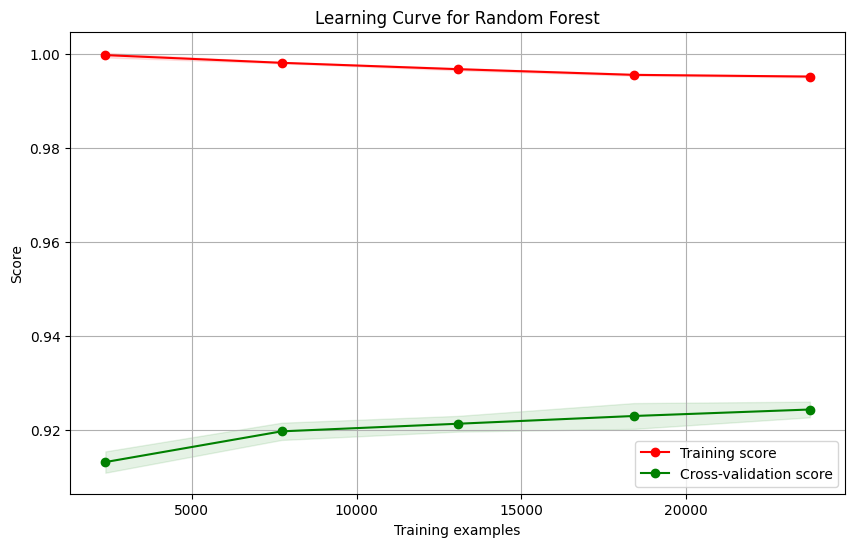

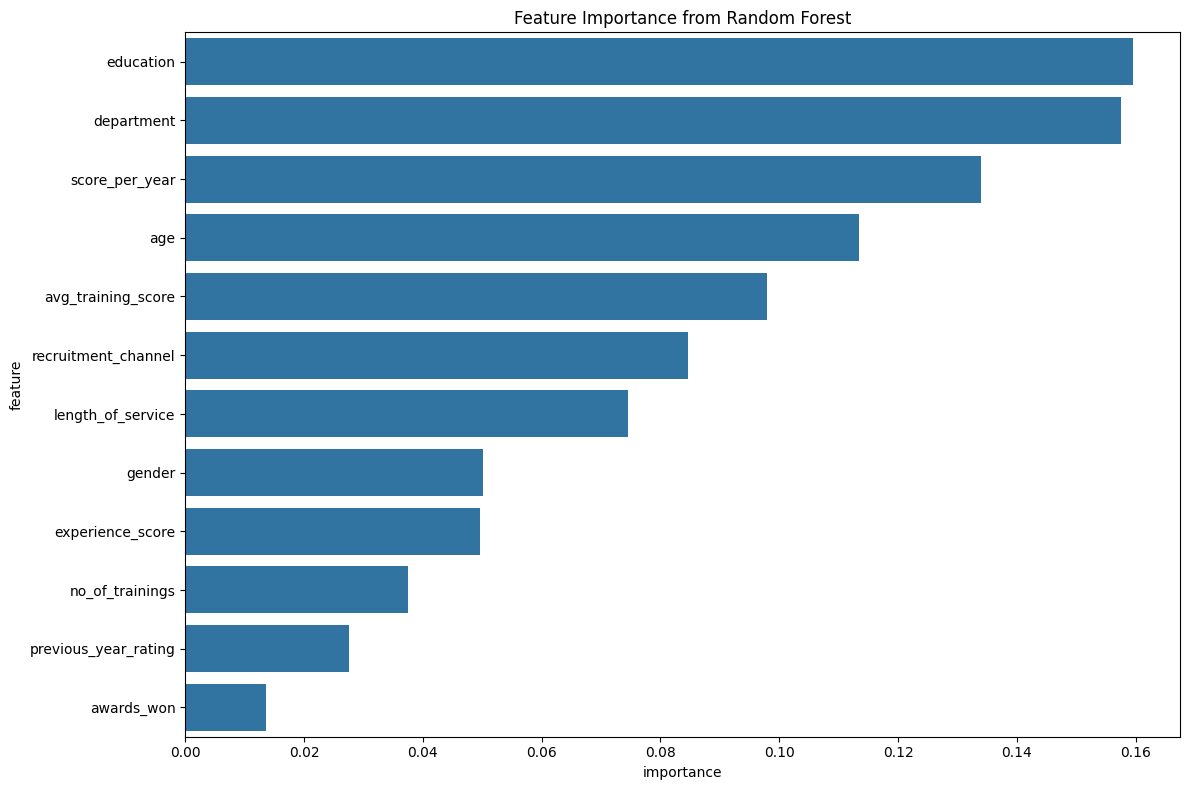

In [38]:
rf_model = models["Random Forest"]
rf_model.fit(x_train, y_train)

plot_learning_curve(
    rf_model,
    f"Learning Curve for Random Forest",
    x_train,
    y_train,
    cv=5,
    n_jobs=-1,
)
plt.show()

feature_names = df.drop(
    ["is_promoted"], axis=1
).columns
feature_importances = pd.DataFrame(
    {"feature": feature_names, "importance": rf_model.feature_importances_}
).sort_values("importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=feature_importances)
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()

Learning Curve for Random Forest
This plot shows how the model's performance changes as the training dataset size increases. The red curve (training score) remains near perfect, indicating the model fits the training data very well. The green curve (cross-validation score) starts lower but increases and stabilizes as more data is used, indicating that the model generalizes better with more examples. The consistent gap between training and validation scores suggests some overfitting, though generalization remains strong.

Feature Importance from Random Forest
This horizontal bar chart ranks the features by how much they contribute to the model’s decision-making. The most influential variables are department, education, and score_per_year, meaning these attributes play a key role in predicting promotions. Surprisingly, features like awards_won and previous_year_rating had relatively low importance, suggesting they may not be strong indicators of promotion in this dataset.

Top selected features:
['recruitment_channel', 'previous_year_rating', 'awards_won', 'avg_training_score', 'experience_score', 'score_per_year', 'rating_score_interaction']

Logistic Regression Results
Best threshold (based on F1): 0.17
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     12812
           1       0.31      0.42      0.36      1375

    accuracy                           0.85     14187
   macro avg       0.63      0.66      0.64     14187
weighted avg       0.88      0.85      0.86     14187



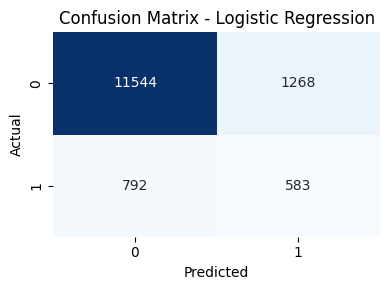


Random Forest Results
Best threshold (based on F1): 0.29
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     12812
           1       0.35      0.36      0.36      1375

    accuracy                           0.87     14187
   macro avg       0.64      0.64      0.64     14187
weighted avg       0.88      0.87      0.87     14187



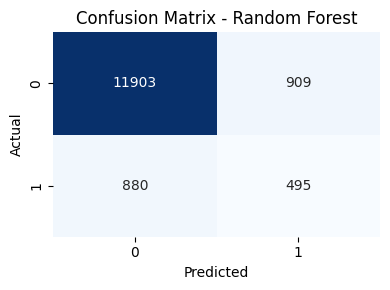


Gradient Boosting Results
Best threshold (based on F1): 0.20
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     12812
           1       0.39      0.44      0.41      1375

    accuracy                           0.88     14187
   macro avg       0.66      0.68      0.67     14187
weighted avg       0.89      0.88      0.88     14187



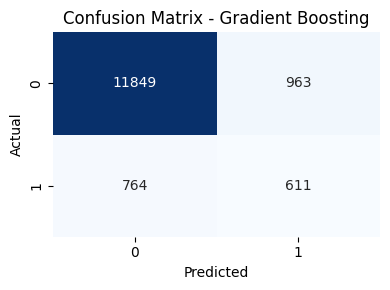


Decision Tree Results
Best threshold (based on F1): 0.26
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     12812
           1       0.31      0.31      0.31      1375

    accuracy                           0.87     14187
   macro avg       0.62      0.62      0.62     14187
weighted avg       0.87      0.87      0.87     14187



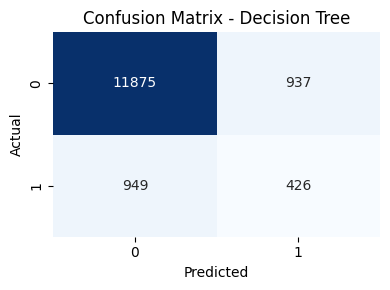


Neural Network Results
Best threshold (based on F1): 0.18
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     12812
           1       0.41      0.42      0.42      1375

    accuracy                           0.89     14187
   macro avg       0.68      0.68      0.68     14187
weighted avg       0.89      0.89      0.89     14187



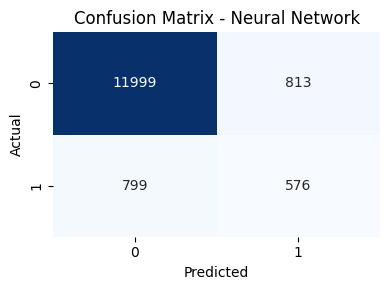

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from imblearn.under_sampling import TomekLinks
import seaborn as sns
import matplotlib.pyplot as plt

#LOAD DATa
df = pd.read_csv("employee_promotion_updated.csv")

# CLEANING
df.drop(columns=['employee_id'], inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df['experience_score'] = df['no_of_trainings'] * df['avg_training_score']
df['score_per_year'] = df['experience_score'] / (df['length_of_service'] + 1)
df['rating_score_interaction'] = df['previous_year_rating'] * df['avg_training_score']

#TEMPORARY ENCODING FOR FEATURE SELECTION
df_fs = df.copy()
cat_cols = df_fs.select_dtypes(include='object').columns
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df_fs[col] = le.fit_transform(df_fs[col].astype(str))
    label_encoders[col] = le

X_fs = df_fs.drop(columns=['is_promoted'])
y_fs = df_fs['is_promoted']

#FEATURE SELECTION USING MUTUAL INFORMATION
selector = SelectKBest(score_func=mutual_info_classif, k=7)
X_selected = selector.fit_transform(X_fs, y_fs)
selected_features = X_fs.columns[selector.get_support()].tolist()
print("Top selected features:")
print(selected_features)

# ONE-HOT ENCODING OF ORIGINAL DATA
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

#Keep selected features that exist post-encoding
available_features = [f for f in selected_features if f in df_encoded.columns]
X = df_encoded[available_features]
y = df_encoded['is_promoted']

#TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# BALANCING WITH SMOTE
smote = TomekLinks(sampling_strategy='majority')
X_train, y_train = smote.fit_resample(X_train, y_train)

#SCALING
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#MODEL DEFINITIONS
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Neural Network": MLPClassifier(max_iter=500, random_state=42)
}

for name, model in models.items():
    print(f"\n{name} Results")
    model.fit(X_train, y_train)

    # Predict probabilities if available
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    # Find best threshold using F1 score
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    best_threshold = thresholds[np.argmax(f1_scores)]

    print(f"Best threshold (based on F1): {best_threshold:.2f}")

    # Final predictions
    y_pred = (y_proba >= best_threshold).astype(int)

    # Evaluation
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


In relation to the previously obtained results,these tables show the following changes:

Logistic Regression - lower rate of false positives but worse rate of false negatives.

Random Forest - worse overall results, specially in the false positive rate.

Gradient Boosting - worse overall results, slight increase in recall average.

Decision Tree - slight decrease in all metrics.

Neural Network - slight increase in 0 precision, decrease in all other metrics.

All of these results have roughly the same f1-scores (0.87) and 0 precision (0.94). Neural Network has the greatest 1 precision (0.35) while Decision Tree has the best 0 recall (0.93) and Gradient Boosting has the best 1 recall (0.51).

Top selected features:
['education', 'no_of_trainings', 'previous_year_rating', 'awards_won', 'avg_training_score', 'experience_score', 'score_per_year', 'rating_score_interaction']

 Logistic Regression Results
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     12812
           1       0.64      0.07      0.13      1375

    accuracy                           0.91     14187
   macro avg       0.77      0.53      0.54     14187
weighted avg       0.88      0.91      0.87     14187



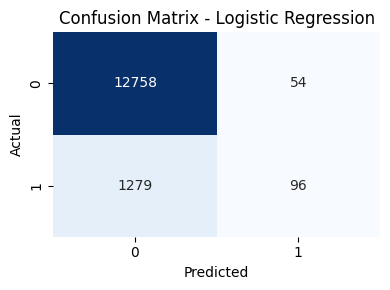


 Random Forest Results
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     12812
           1       0.50      0.20      0.29      1375

    accuracy                           0.90     14187
   macro avg       0.71      0.59      0.62     14187
weighted avg       0.88      0.90      0.88     14187



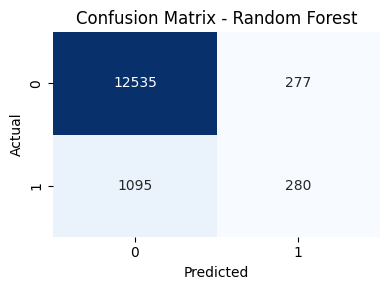


 Gradient Boosting Results
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     12812
           1       0.70      0.18      0.29      1375

    accuracy                           0.91     14187
   macro avg       0.81      0.59      0.62     14187
weighted avg       0.90      0.91      0.89     14187



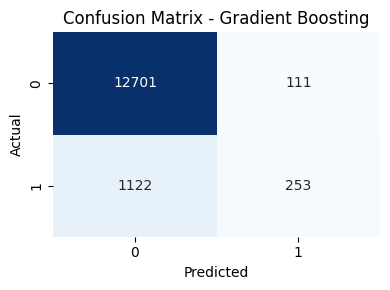


 Decision Tree Results
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     12812
           1       0.48      0.20      0.28      1375

    accuracy                           0.90     14187
   macro avg       0.70      0.59      0.62     14187
weighted avg       0.88      0.90      0.88     14187



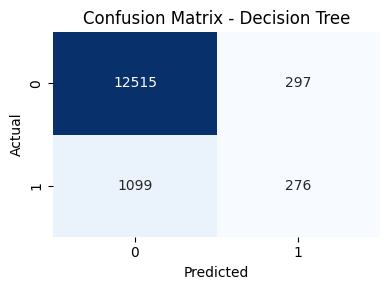


 Neural Network Results
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     12812
           1       0.57      0.16      0.24      1375

    accuracy                           0.91     14187
   macro avg       0.74      0.57      0.60     14187
weighted avg       0.88      0.91      0.88     14187



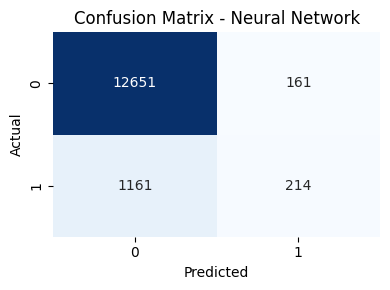

In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Copy original data
df_fs = df.copy()

# Temporarily Label Encode categorical columns
cat_cols = df_fs.select_dtypes(include='object').columns
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df_fs[col] = le.fit_transform(df_fs[col].astype(str))
    label_encoders[col] = le

# Define features and target
X_fs = df_fs.drop(columns=['is_promoted'])
y_fs = df_fs['is_promoted']

# Apply Chi-Square feature selection
selector = SelectKBest(score_func=chi2, k=8)  
X_selected = selector.fit_transform(X_fs, y_fs)
selected_feature_names = X_fs.columns[selector.get_support()].tolist()

print("Top selected features:")
print(selected_feature_names)

# One-hot encode categorical columns from original df
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Align selected features with the one-hot encoded dataframe
available_features = [f for f in selected_feature_names if f in df_encoded.columns]
X = df_encoded[available_features]
y = df_encoded['is_promoted']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Neural Network": MLPClassifier(max_iter=500)
}

#Train and evaluate models
for name, model in models.items():
    print(f"\n {name} Results")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

There was a very slight improvement in f1-score in all of the results.

Most results are now more conservative, making the 0 recall and 1 precision increase while the 1 recall decrease in all of them.

Gradient Boosting has the best overall results, with the best f1-score (0.89), 0 and 1 precision (0.92/0.70) with nearly perfect 0 recall (0.99) as well as accuracy (0.91). Random Forest has the best 1 recall results (0.21).

/Users/franciscomoura/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/franciscomoura/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/franciscomoura/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/franciscomoura/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/franciscomoura/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

Best Parameters: {'learning_rate': 0.1, 'max_depth': 24, 'min_child_samples': 24, 'n_estimators': 206, 'num_leaves': 91}

Best threshold (based on F1): 0.94

Classification Report:
              precision    recall  f1-score   support

           0     0.9399    0.9721    0.9558     12812
           1     0.6186    0.4211    0.5011      1375

    accuracy                         0.9187     14187
   macro avg     0.7793    0.6966    0.7284     14187
weighted avg     0.9088    0.9187    0.9117     14187


Class 1 Precision: 0.6186
Class 1 Recall:    0.4211
Class 1 F1-score:  0.5011


/Users/franciscomoura/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


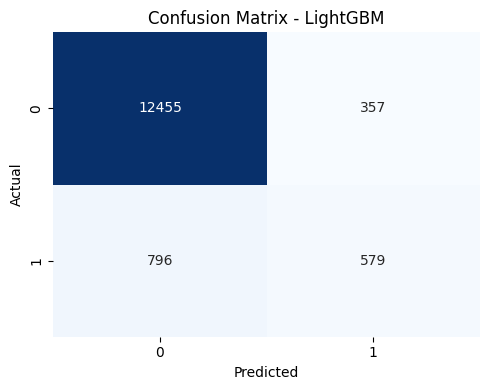

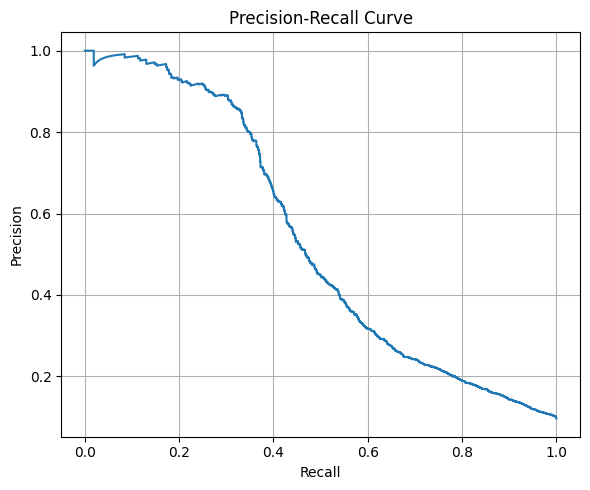

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    confusion_matrix
)
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

#Load e Clean Data
df = pd.read_csv("employee_promotion_updated.csv")
df.drop(columns=['employee_id'], inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df['experience_score'] = df['no_of_trainings'] * df['avg_training_score']
df['score_per_year'] = df['experience_score'] / (df['length_of_service'] + 1)
df['rating_score_interaction'] = df['previous_year_rating'] * df['avg_training_score']

cat_cols = df.select_dtypes(include='object').columns

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)


X = df_encoded.drop(columns=['is_promoted'])
y = df_encoded['is_promoted']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

#Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LightGBM Setup 
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
lgbm = LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1 
)

# Hyperparameter Search Space
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 25),
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': randint(20, 100),
    'min_child_samples': randint(10, 100)
}

search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1_macro',
    random_state=42,
    n_jobs=-1
)


search.fit(X_train_scaled, y_train)
best_lgbm = search.best_estimator_

print("Best Parameters:", search.best_params_)

#Predict Probabilities
y_proba = best_lgbm.predict_proba(X_test_scaled)[:, 1]

# Threshold Tuning
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nBest threshold (based on F1): {best_threshold:.2f}")

# Final Predictions
y_pred = (y_proba >= best_threshold).astype(int)

# Classification Report
print("\nClassification Report:")
report_text = classification_report(y_test, y_pred, digits=4, zero_division=0)
print(report_text)

# Extract class 1 performance for clarity
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print(f"\nClass 1 Precision: {report_dict['1']['precision']:.4f}")
print(f"Class 1 Recall:    {report_dict['1']['recall']:.4f}")
print(f"Class 1 F1-score:  {report_dict['1']['f1-score']:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LightGBM")
plt.tight_layout()
plt.show()

# PR Curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.tight_layout()
plt.show()
